In [1]:

####################################################################################################
####################################################################################################

import sys
import os.path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display
from IPython.display import Image


##########################################################################################
##########################################################################################

import keras
import keras.utils.vis_utils
from keras import backend as K
from keras import layers
from keras.layers import Dense
from keras.models import load_model
from keras.models import Sequential
from keras.utils import plot_model


Using TensorFlow backend.


In [17]:

####################################################################################################
####################################################################################################

df_train_truth = pd.DataFrame.from_csv("../python_pax_reader/data/train_truth.csv")
df_train_input = pd.DataFrame.from_csv("../python_pax_reader/data/train_input.csv")



In [20]:

####################################################################################################
# First 127 are S2
####################################################################################################

df_train_input = df_train_input.iloc[:, 0:127]
df_train_input.shape


,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c118,c119,c120,c121,c122,c123,c124,c125,c126,c127
1,3040161,0,0,1631966,3424616,0,0,1632058,1600037,0,...,3456052,0,1632116,2975965,2911431,3998442,4220343,4223085,2783925,3933417
2,0,0,0,0,0,0,1631794,0,0,0,...,1920177,0,0,2271984,2047402,0,0,0,0,0
3,2720343,0,0,0,3008661,0,2719313,4143735,1600059,2655947,...,3040005,0,0,3583825,3645234,4648453,4573002,3613724,3680111,3964693


(924, 127)

In [21]:

####################################################################################################
####################################################################################################

nRows = 5

print()
display(df_train_truth[0:nRows][:])
print()
display(df_train_input[0:nRows][:])
print()



,x,y
1,2.626434,-17.960824
2,-32.844888,-21.247503
3,10.907536,-6.312277
5,24.631697,-12.763601
6,2.726006,37.749081


,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c118,c119,c120,c121,c122,c123,c124,c125,c126,c127
1,3040161,0,0,1631966,3424616,0,0,1632058,1600037,0,...,3456052,0,1632116,2975965,2911431,3998442,4220343,4223085,2783925,3933417
2,0,0,0,0,0,0,1631794,0,0,0,...,1920177,0,0,2271984,2047402,0,0,0,0,0
3,2720343,0,0,0,3008661,0,2719313,4143735,1600059,2655947,...,3040005,0,0,3583825,3645234,4648453,4573002,3613724,3680111,3964693
5,1632026,0,3935957,3231596,1104122,0,2111364,2096172,2240101,1632041,...,1631931,0,1600269,3600074,4959183,3599730,3072779,4159783,1712096,3390560
6,4543933,0,4063043,4541811,3518826,1952352,4159031,3360242,1631984,2655808,...,0,0,0,1888285,0,0,1632440,0,1632131,0


In [27]:

##########################################################################################
##########################################################################################

num_input_nodes = 127


##########################################################################################
##########################################################################################

act = 'linear'

model = Sequential()
model.add(Dense(127, activation=act, input_dim=num_input_nodes))
model.add(Dense(100, activation=act))
model.add(Dense(100, activation=act))
model.add(Dense( 40, activation=act))
model.add(Dense( 40, activation=act))
model.add(Dense( 20, activation=act))
model.add(Dense( 20, activation=act))
model.add(Dense(  2, activation='sigmoid'))


##########################################################################################
##########################################################################################



In [28]:

##########################################################################################
##########################################################################################

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mean_absolute_error'            , optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mean_absolute_percentage_error' , optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mean_squared_logarithmic_error' , optimizer='adam', metrics=['accuracy'])
#model.compile(loss='squared_hinge'                  , optimizer='adam', metrics=['accuracy'])
#model.compile(loss='hinge'                          , optimizer='adam', metrics=['accuracy'])
#model.compile(loss='categorical_hinge'              , optimizer='adam', metrics=['accuracy'])
#model.compile(loss='logcosh'                        , optimizer='adam', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy'       , optimizer='adam', metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='binary_crossentropy'            , optimizer='adam', metrics=['accuracy'])
#model.compile(loss='kullback_leibler_divergence'    , optimizer='adam', metrics=['accuracy'])
#model.compile(loss='poisson'                        , optimizer='adam', metrics=['accuracy'])
#model.compile(loss='cosine_proximity'               , optimizer='adam', metrics=['accuracy'])


##########################################################################################
##########################################################################################

print(df_train_input.shape)
print(df_train_truth.shape)


(924, 127)
(924, 2)


In [29]:

##########################################################################################
##########################################################################################

model.fit(df_train_input, df_train_truth, epochs=5, batch_size=32, verbose=1)
print("Done")


Epoch 1/5
924/924 [==============================] - 1s 1ms/step - loss: 400.4253 - acc: 0.4784
Epoch 2/5
924/924 [==============================] - 0s 179us/step - loss: 399.6997 - acc: 0.4848
Epoch 3/5
924/924 [==============================] - 0s 165us/step - loss: 399.3294 - acc: 0.4870
Epoch 4/5
924/924 [==============================] - 0s 170us/step - loss: 399.6510 - acc: 0.4892
Epoch 5/5
924/924 [==============================] - 0s 172us/step - loss: 399.6975 - acc: 0.4870
Done


In [30]:

##########################################################################################
##########################################################################################

folder   = "models" + "/"    
name     = "model_posreco"
name_h5  = folder + name + ".h5"
name_png = folder + name + ".png"


##########################################################################################
##########################################################################################

model.save(name_h5, overwrite=True)



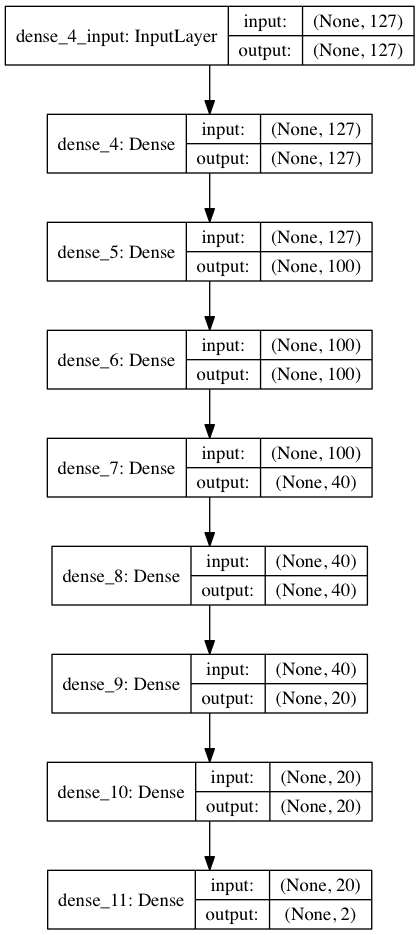

In [31]:

##########################################################################################
##########################################################################################

plot_model(model, to_file=name_png, show_layer_names=True, show_shapes=True)

print()
Image(filename=name_png) 


In [ ]:

##########################################################################################
# Convergence Plots
##########################################################################################
